In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import polars as pl
import statsmodels.api as sm

In [60]:
# Read in data
df = pd.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/profiles/mad_featselect.parquet")
df["Metadata_Log10Conc"] = np.round(df["Metadata_Log10Conc"], 2)
df.loc[df["Metadata_ldh_ridge_norm"].isna(), "Metadata_ldh_normalized"] = pd.NA
df = df[df["Metadata_Compound"]!="DMSO"]
df.loc[df["Metadata_ldh_ridge_norm"].isna(), "Metadata_ldh_normalized"] = pd.NA

# Well position normalization
df = (
    pl.from_pandas(df)
    .with_columns([
        (pl.col("Metadata_ldh_normalized") - pl.median("Metadata_ldh_normalized").over("Metadata_Well")).alias("Metadata_ldh_normalized_corrected"),
        (pl.col("Metadata_mtt_normalized") - pl.median("Metadata_mtt_normalized").over("Metadata_Well")).alias("Metadata_mtt_normalized_corrected")
    ])
    .to_pandas()
)

# Compute residuals between cc and mtt
X = df["Metadata_Count_Cells"]
y = df["Metadata_mtt_normalized"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

df["Metadata_mtt_cc_resid"] = model.resid

# Compute residuals between cc and mtt_corrected
X = df["Metadata_Count_Cells"]
y = df["Metadata_mtt_normalized_corrected"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

df["Metadata_mtt_cc_resid_corrected"] = model.resid


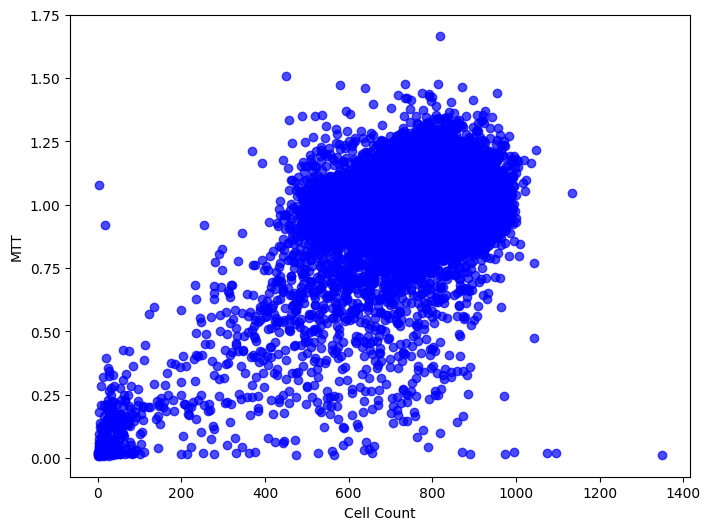

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Metadata_Count_Cells"], df["Metadata_mtt_normalized"], alpha=0.7, c="blue")
plt.xlabel("Cell Count")
plt.ylabel("MTT")
plt.show()

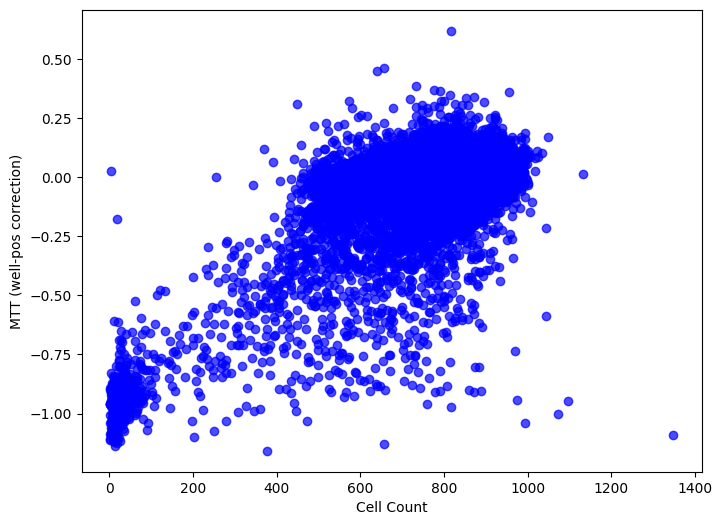

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Metadata_Count_Cells"], df["Metadata_mtt_normalized_corrected"], alpha=0.7, c="blue")
plt.xlabel("Cell Count")
plt.ylabel("MTT (well-pos correction)")
plt.show()

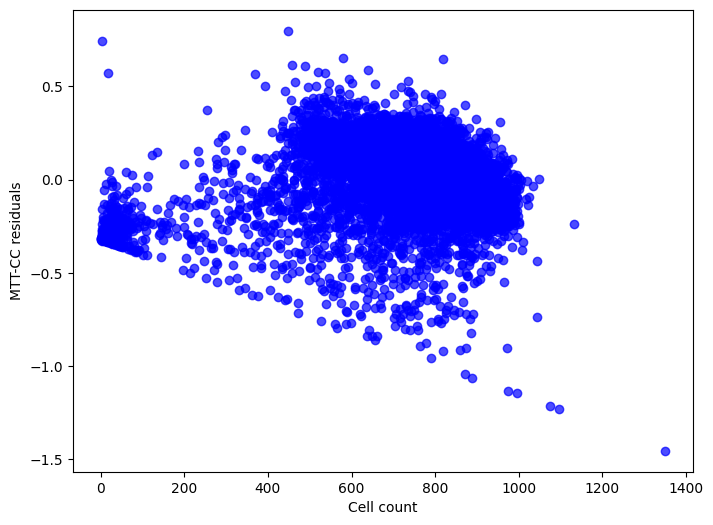

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Metadata_Count_Cells"], df["Metadata_mtt_cc_resid"], alpha=0.7, c="blue")
plt.xlabel("Cell count")
plt.ylabel("MTT-CC residuals")
plt.show()

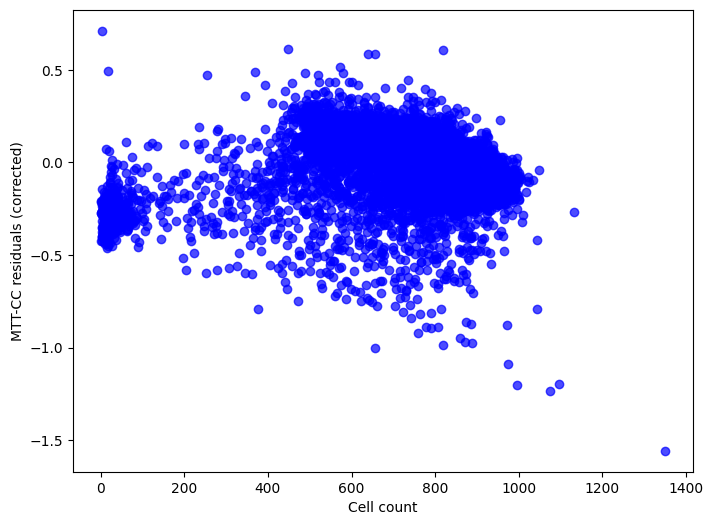

: 

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df["Metadata_Count_Cells"], df["Metadata_mtt_cc_resid_corrected"], alpha=0.7, c="blue")
plt.xlabel("Cell count")
plt.ylabel("MTT-CC residuals (corrected)")
plt.show()

## Cell Count layout

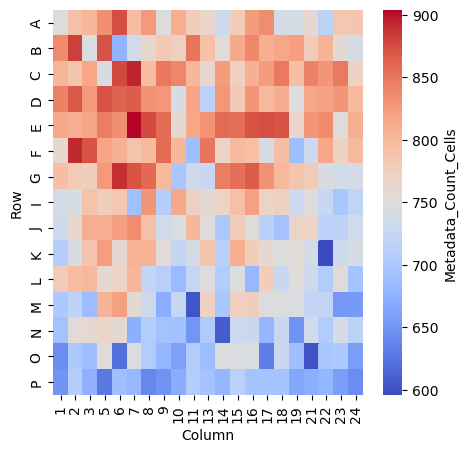

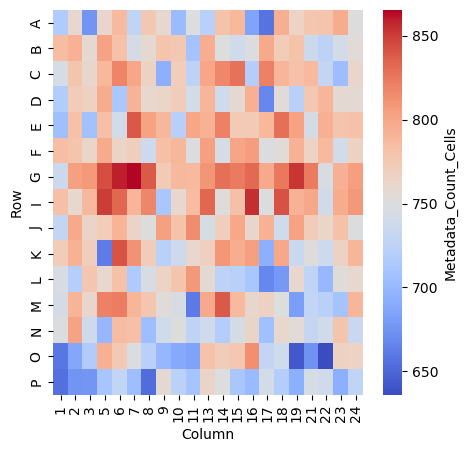

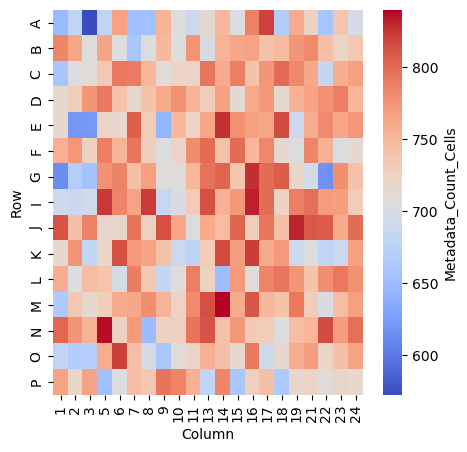

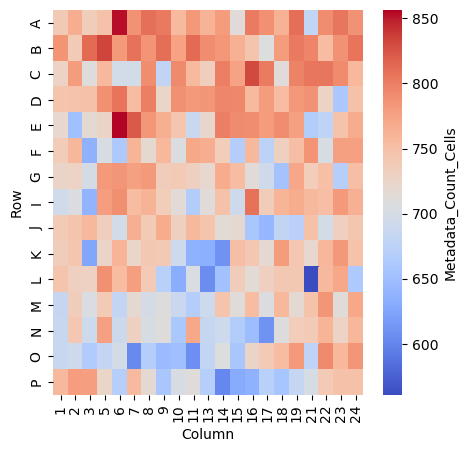

In [ ]:
for source in df.Metadata_source.unique():
    
    df_source = df[df["Metadata_source"]==source].groupby("Metadata_Well").mean().reset_index()
    
    df_source['Row'] = df_source['Metadata_Well'].str[0]  
    df_source['Column'] = df_source['Metadata_Well'].str[1:]  
    df_source['Column'] = df_source['Column'].astype(int)

    # Pivot the table for the heatmap
    df_source = df_source.pivot(index='Row', columns='Column', values='Metadata_Count_Cells')

    # Plot the heatmap with bidirectional colormap, ensuring 0 is white, 1 is red, and -1 is blue
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        df_source, 
        annot=False, 
        cmap='coolwarm',  # Coolwarm colormap aligns -1 to blue, 1 to red, and 0 to white
        fmt=".2f", 
        cbar_kws={'label': 'Metadata_Count_Cells'}
    )
    plt.show()


## LDH_normalized

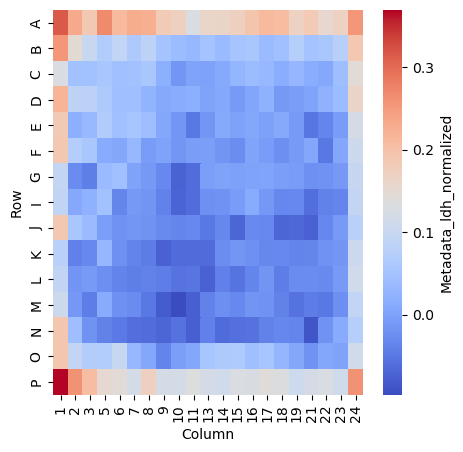

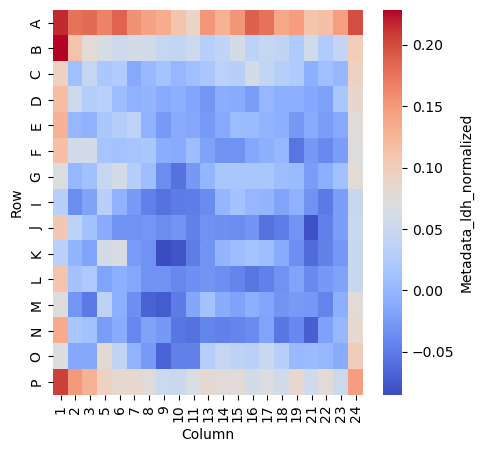

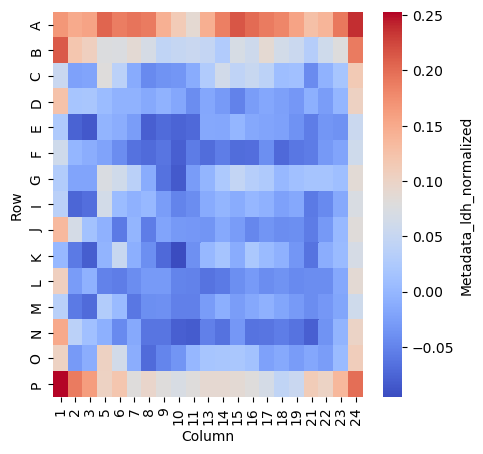

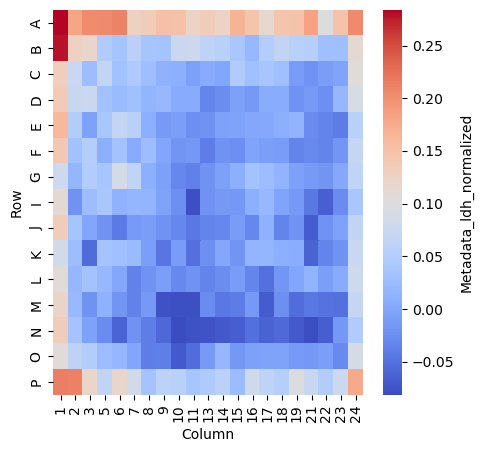

In [ ]:
for source in df.Metadata_source.unique():
    
    df_source = df[df["Metadata_source"]==source].groupby("Metadata_Well").median().reset_index()
    
    df_source['Row'] = df_source['Metadata_Well'].str[0]  
    df_source['Column'] = df_source['Metadata_Well'].str[1:]  
    df_source['Column'] = df_source['Column'].astype(int)

    # Pivot the table for the heatmap
    df_source = df_source.pivot(index='Row', columns='Column', values='Metadata_ldh_normalized')

    # Plot the heatmap with bidirectional colormap, ensuring 0 is white, 1 is red, and -1 is blue
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        df_source, 
        annot=False, 
        cmap='coolwarm',  # Coolwarm colormap aligns -1 to blue, 1 to red, and 0 to white
        fmt=".2f", 
        cbar_kws={'label': 'Metadata_ldh_normalized'}
    )
    plt.show()


## MTT_normalized

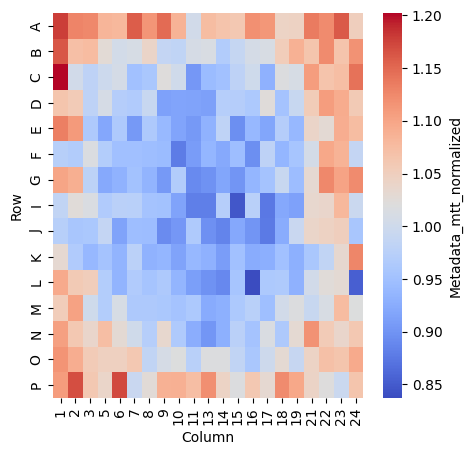

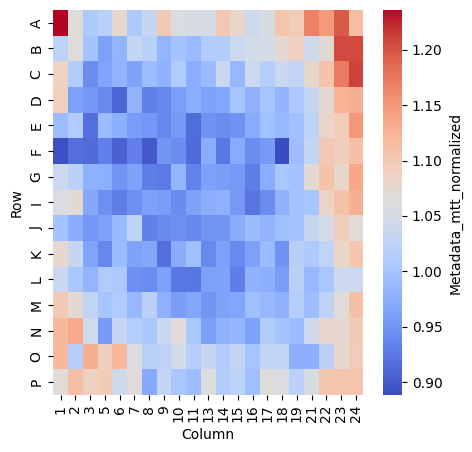

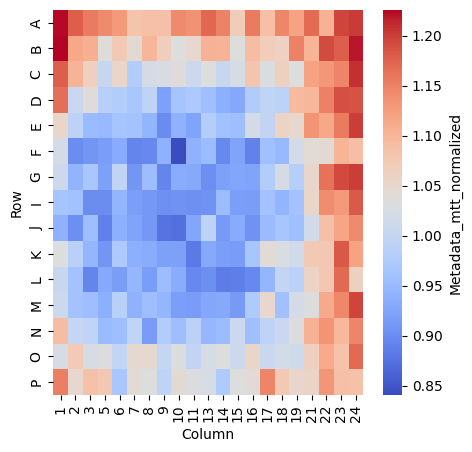

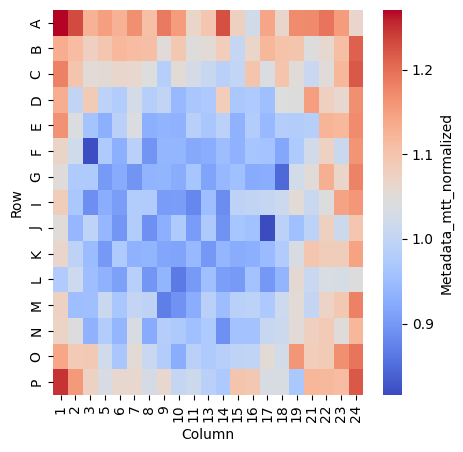

In [6]:
pred_var = 'Metadata_mtt_normalized'
for source in df.Metadata_source.unique():
    # Filter rows for the current source
    df_source = df[df["Metadata_source"] == source]
    
    # Group by "Metadata_Well" and calculate the median for numeric columns only
    df_source = (
        df_source.groupby("Metadata_Well")
        .median(numeric_only=True)
        .reset_index()
    )
    
    # Extract row and column from "Metadata_Well"
    df_source['Row'] = df_source['Metadata_Well'].str[0]  # First character is Row
    df_source['Column'] = df_source['Metadata_Well'].str[1:]  # Rest is Column
    df_source['Column'] = df_source['Column'].astype(int)

    # Pivot the table for the heatmap
    df_source = df_source.pivot(index='Row', columns='Column', values=pred_var)

    # Plot the heatmap with bidirectional colormap
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        df_source, 
        annot=False, 
        cmap='coolwarm',
        fmt=".2f", 
        cbar_kws={'label': pred_var}
    )
    plt.show()


## LDH_ridge_norm

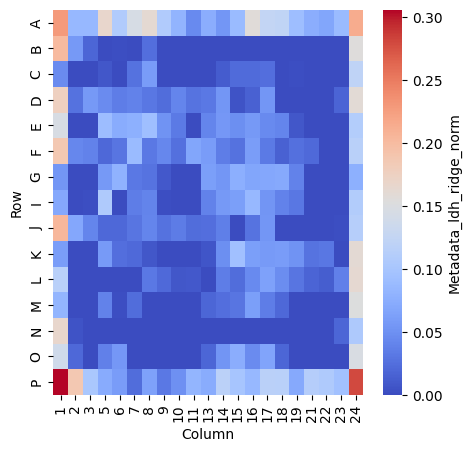

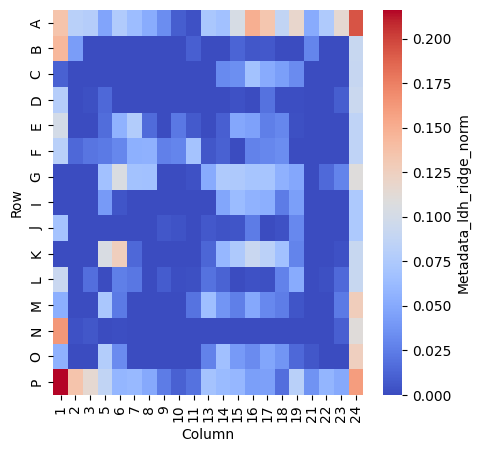

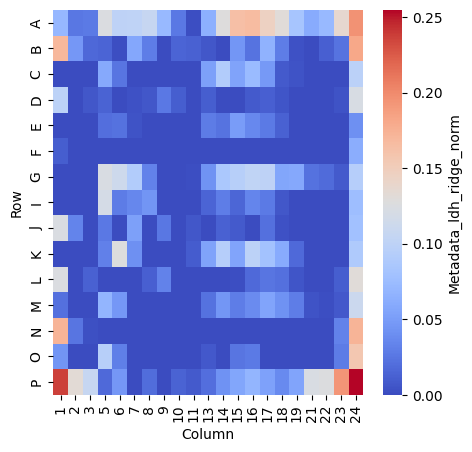

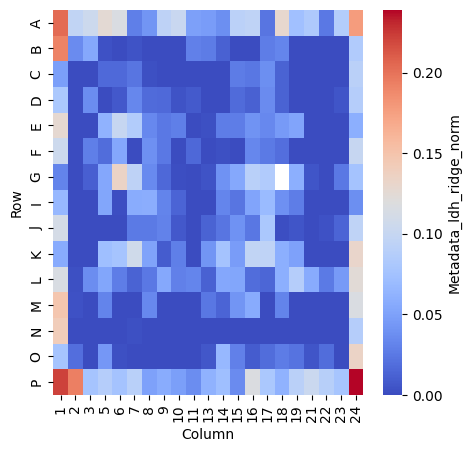

In [7]:
pred_var = 'Metadata_ldh_ridge_norm'
for source in df.Metadata_source.unique():
    # Filter rows for the current source
    df_source = df[df["Metadata_source"] == source]
    
    # Group by "Metadata_Well" and calculate the median for numeric columns only
    df_source = (
        df_source.groupby("Metadata_Well")
        .median(numeric_only=True)
        .reset_index()
    )
    
    # Extract row and column from "Metadata_Well"
    df_source['Row'] = df_source['Metadata_Well'].str[0]  # First character is Row
    df_source['Column'] = df_source['Metadata_Well'].str[1:]  # Rest is Column
    df_source['Column'] = df_source['Column'].astype(int)

    # Pivot the table for the heatmap
    df_source = df_source.pivot(index='Row', columns='Column', values=pred_var)

    # Plot the heatmap with bidirectional colormap
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        df_source, 
        annot=False, 
        cmap='coolwarm',
        fmt=".2f", 
        cbar_kws={'label': pred_var}
    )
    plt.show()


## MTT_ridge_norm

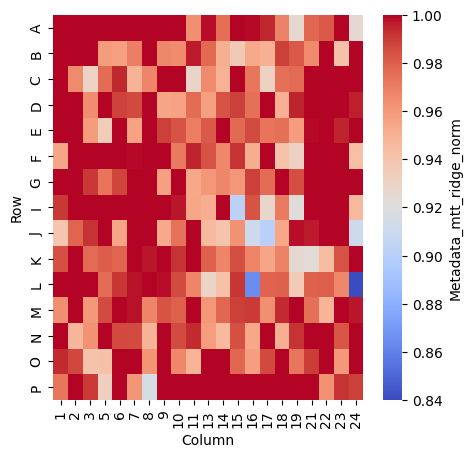

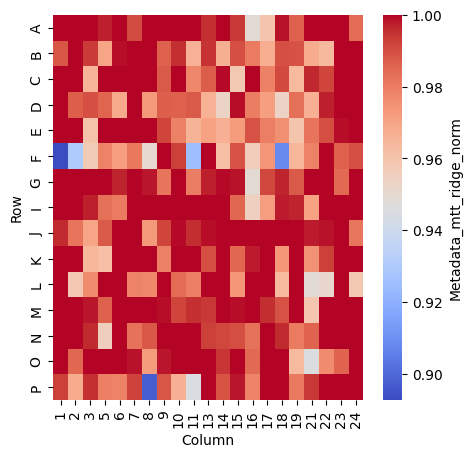

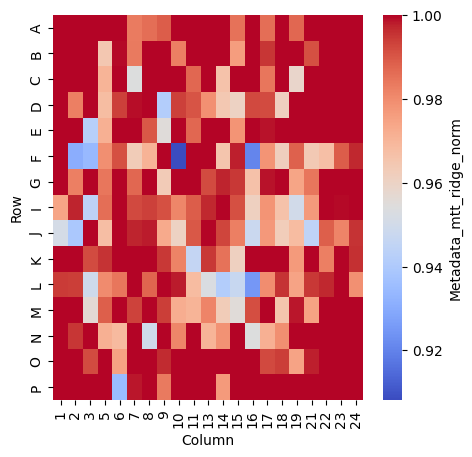

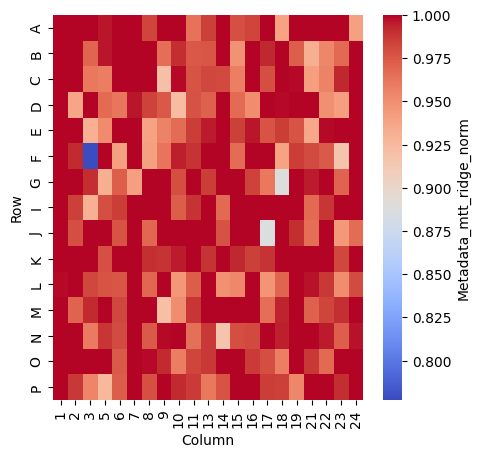

In [8]:
pred_var = 'Metadata_mtt_ridge_norm'
for source in df.Metadata_source.unique():
    # Filter rows for the current source
    df_source = df[df["Metadata_source"] == source]
    
    # Group by "Metadata_Well" and calculate the median for numeric columns only
    df_source = (
        df_source.groupby("Metadata_Well")
        .median(numeric_only=True)
        .reset_index()
    )
    
    # Extract row and column from "Metadata_Well"
    df_source['Row'] = df_source['Metadata_Well'].str[0]  # First character is Row
    df_source['Column'] = df_source['Metadata_Well'].str[1:]  # Rest is Column
    df_source['Column'] = df_source['Column'].astype(int)

    # Pivot the table for the heatmap
    df_source = df_source.pivot(index='Row', columns='Column', values=pred_var)

    # Plot the heatmap with bidirectional colormap
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        df_source, 
        annot=False, 
        cmap='coolwarm',
        fmt=".2f", 
        cbar_kws={'label': pred_var}
    )
    plt.show()
